In [27]:
import pandas as pd

from collections import defaultdict

import random
import numpy as np

from surprise import Dataset, Reader
from surprise import BaselineOnly


from surprise.model_selection import cross_validate
from surprise import SVD, KNNBasic, SVDpp, NMF, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.dump import dump


from sklearn.metrics.pairwise import cosine_similarity

In [33]:
DATASET_PATH = "./datasets/Refined/dataset.parquet"
TEST_SIZE = .25

In [34]:
seed = 608
random.seed(seed)
np.random.seed(seed)

In [35]:
data = pd.read_parquet(DATASET_PATH)
data.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5


In [36]:
min_rating = data["rating"].min()
max_rating = data["rating"].max()

In [37]:
reader = Reader(rating_scale=(min_rating, max_rating))
dataset = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

In [38]:
cross_validate(BaselineOnly(), dataset, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8736  0.8724  0.8714  0.8796  0.8646  0.8723  0.0048  
MAE (testset)     0.6741  0.6729  0.6700  0.6776  0.6681  0.6725  0.0033  
Fit time          0.44    0.63    0.43    0.57    0.48    0.51    0.08    
Test time         0.92    0.11    0.14    0.14    0.38    0.34    0.31    


{'test_rmse': array([0.87361888, 0.87242742, 0.87135281, 0.87955244, 0.86462855]),
 'test_mae': array([0.67409083, 0.67289043, 0.66995537, 0.67764192, 0.66810451]),
 'fit_time': (0.4420037269592285,
  0.6312055587768555,
  0.4273681640625,
  0.568011999130249,
  0.4817221164703369),
 'test_time': (0.9161310195922852,
  0.1064457893371582,
  0.14370346069335938,
  0.14109230041503906,
  0.3806276321411133)}

In [10]:
def build_svg_algo(prediction_algorithm, dataset):
    param_grid = {
        'n_factors': [20, 50, 100],
        'n_epochs': [5, 10, 20, 30, 40, 50],
        "lr_all": [0.01, 0.2, 0.05, 0.001, 0.002, 0.005],
        "reg_all": [0.4, 0.6]
    }
   
    gs = GridSearchCV(prediction_algorithm, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs=-1)
    gs.fit(dataset)
    
    print(f"SVG RMSE: {gs.best_score['rmse']}")
    print(f"SVG BEST PARAMS: {gs.best_params['rmse']} \n")

    algo = gs.best_estimator["rmse"]
    return algo

In [11]:
def knn_with_search(prediction_algorithm, dataset):
    sim_options = {
        # "name": ["msd", "cosine", "pearson"],
        "name": ["pearson"],
        "user_based": [False],  # compute  similarities between items
        'verbose' : True
    }
    
    param_grid = {
        'sim_options': sim_options,
        'k': [50],
        # 'n_epochs': [5, 10, 20],
        # "lr_all": [0.001,0.002, 0.005],
        # "reg_all": [0.4, 0.6]
    }
   
    gs = GridSearchCV(prediction_algorithm, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs=1)
    gs.fit(dataset)
    
    print(f"KNN RMSE: {gs.best_score['rmse']}")
    print(f"KNN BEST PARAMS: {gs.best_params['rmse']} \n")
    print(f"KNN BEST PARAMS: {gs.best_params['mae']} \n")

    # O algo possui os melhorar parametros
    algo = gs.best_estimator["rmse"]
    return algo
    

In [12]:
def build_knn_algo(prediction_algorithm, dataset, k, sim_options, with_search=False):
    if (with_search):
        return knn_with_search()

    
    algo = prediction_algorithm(k, sim_options)
    algo.fit(dataset)
    
    return algo

In [13]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [39]:
train_set, test_set = train_test_split(dataset, test_size=TEST_SIZE)

In [16]:
svd_algo = build_svg_algo(SVD, dataset)


SVG RMSE: 0.8643605664755516
SVG BEST PARAMS: {'n_factors': 20, 'n_epochs': 30} 



In [42]:
svd_pp_algo = build_svg_algo(SVDpp, dataset)

SVG RMSE: 0.8570127821130431
SVG BEST PARAMS: {'n_factors': 20, 'n_epochs': 20} 



In [20]:
svd_nmf_algo = build_svg_algo(NMF, dataset)

SVG RMSE: 0.9151355727273908
SVG BEST PARAMS: {'n_factors': 20, 'n_epochs': 50} 



In [ ]:
svd_algo = build_svg_algo(SVD, dataset)

In [ ]:
knn_basic_algo = knn_with_search(KNNBasic, dataset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [28]:
knn_baseline_algo = knn_with_search(KNNBaseline, dataset)

TypeError: 'bool' object is not iterable

In [43]:
svd_algo.fit(train_set)
svd_pp_algo.fit(train_set)
svd_nmf_algo.fit(train_set)

In [ ]:
knn_basic_algo.fit(train_set)


In [44]:
predictions_svd = svd_algo.test(test_set)
predictions_svd_pp = svd_pp_algo.test(test_set)
predictions_svd_nmf = svd_nmf_algo.test(test_set)

In [45]:
dump("svd_algo", predictions_svd, svd_algo)
dump("svd_pp_algo", predictions_svd_pp, svd_pp_algo)
dump("svd_nmf_algo", predictions_svd_nmf, svd_nmf_algo)

In [ ]:
predictions_knn_basic = knn_basic_algo.test(test_set)

In [59]:
top_n_svd = get_top_n(predictions_svd, n=30)
top_n_svd_pp = get_top_n(predictions_svd_pp, n=30)
top_n_svd_nmf = get_top_n(predictions_svd_nmf, n=30)
# top_n_knn_basic = get_top_n(predictions_knn_basic, n=10)

In [61]:
# uid = user, iid = movie
print("SVD")
for uid, user_ratings in top_n_svd.items():
    if(uid == 1):
        print(uid, [data[data["movieId"]==iid]["title"].values[0] for (iid, _) in user_ratings])
        
print("SVD++")
for uid, user_ratings in top_n_svd_pp.items():
    if(uid == 1):
        print(uid, [data[data["movieId"]==iid]["title"].values[0] for (iid, _) in user_ratings])
        
print("NMF")
for uid, user_ratings in top_n_svd_nmf.items():
    if(uid == 1):
        print(uid, [data[data["movieId"]==iid]["title"].values[0] for (iid, _) in user_ratings])
        
# print("KNNBasic")
# for uid, user_ratings in top_n_knn_basic.items():
#     if(uid == 1):
#         print(uid, [data[data["movieId"]==iid]["title"].values[0] for (iid, _) in user_ratings])
        

SVD
['Fargo (1996)', 'Apocalypse Now (1979)', 'Monty Python and the Holy Grail (1975)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Goodfellas (1990)', 'Silence of the Lambs, The (1991)', "Schindler's List (1993)", 'Bottle Rocket (1996)', 'L.A. Confidential (1997)', 'Seven (a.k.a. Se7en) (1995)', 'Shining, The (1980)', 'Toy Story (1995)', 'Heat (1995)', 'Office Space (1999)', 'Lock, Stock & Two Smoking Barrels (1998)', 'Alien (1979)', 'Dr. No (1962)', 'Young Frankenstein (1974)', 'Blues Brothers, The (1980)', 'Goldfinger (1964)', 'Easy Rider (1969)', 'Jurassic Park (1993)', 'Big (1988)', 'Planet of the Apes (1968)', 'Pink Floyd: The Wall (1982)', 'E.T. the Extra-Terrestrial (1982)', 'Mrs. Doubtfire (1993)', 'Excalibur (1981)', 'Grosse Pointe Blank (1997)', 'Wizard of Oz, The (1939)']


In [50]:
movies = pd.read_csv(f'./datasets/raw/movies.csv', encoding='utf-8')

In [62]:
def filter_predictions_for_user(predictions, user_id, movies_df, top_k=10):
    top_preds = sorted([pred for pred in predictions if pred.uid == user_id], key=lambda pred: pred.est, reverse=True)[:top_k]
    movie_ids = [pred.iid for pred in top_preds]
    relevant_movies = movies_df[movies_df["movieId"].isin(movie_ids)]
    relevant_movies['rating'] = [pred.est for pred in top_preds]
    return relevant_movies

svd_redictions_for_user = filter_predictions_for_user(predictions_svd_pp, 1, movies)
# knn_basic_redictions_for_user = filter_predictions_for_user(predictions_knn_basic, 1, movies)

/tmp/ipykernel_998/765858098.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_movies['rating'] = [pred.est for pred in top_preds]


In [63]:
svd_redictions_for_user.head(15)

,movieId,title,genres,rating
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.000000
89,101,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance,5.000000
461,527,Schindler's List (1993),Drama|War,5.000000
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,5.000000
520,608,Fargo (1996),Comedy|Crime|Drama|Thriller,4.894950
863,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,4.892209
900,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.879840
909,1208,Apocalypse Now (1979),Action|Drama|War,4.863795
914,1213,Goodfellas (1990),Crime|Drama,4.825549
1218,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,4.820802


/tmp/ipykernel_998/1010096183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['genres'] = data1['genres'].str.split('|')


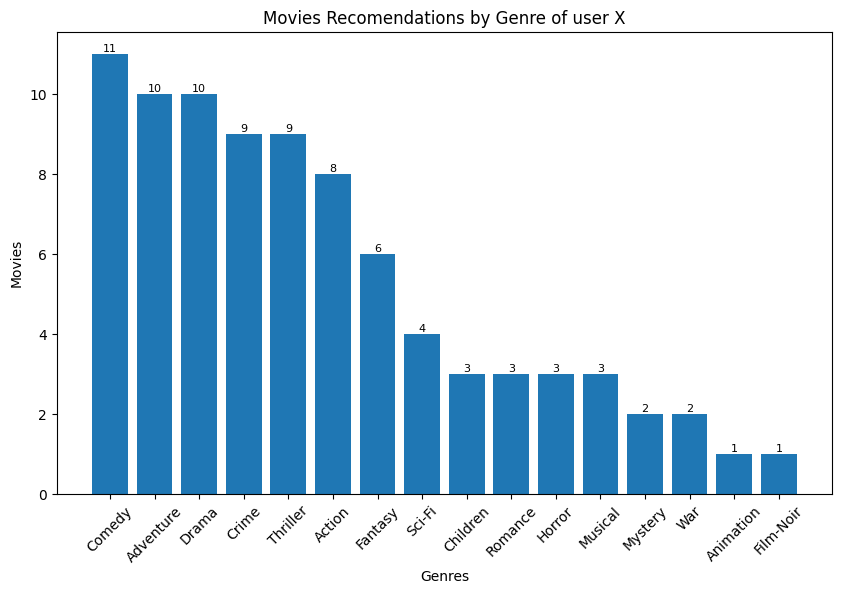

In [65]:
import matplotlib.pyplot as plt
data1 = movies[movies["title"].isin(result)]

data1['genres'] = data1['genres'].str.split('|')

genre_counts = data1.explode('genres')['genres'].value_counts().to_dict()

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(genres, counts)
plt.xlabel('Genres')
plt.ylabel('Movies')
plt.title('Movies Recomendations by Genre of user X')
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontsize=8)

plt.show()

In [ ]:
knn_basic_redictions_for_user.head()

,movieId,title,genres,rating
89,101,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance,4.744659
201,235,Ed Wood (1994),Comedy|Drama,4.675446
509,592,Batman (1989),Action|Crime|Thriller,4.662336
909,1208,Apocalypse Now (1979),Action|Drama|War,4.649677
996,1298,Pink Floyd: The Wall (1982),Drama|Musical,4.616162


In [ ]:
def get_most_similar_movies_svd(movies_df, movie_embeddings, trainset, target_movie_id, top_k=10):
    inner_movie_id = trainset.to_inner_iid(target_movie_id)
    sims = cosine_similarity(movie_embeddings, movie_embeddings)
    target_movie_sims_sorted = [trainset.to_raw_iid(x) for x in np.argsort(sims[inner_movie_id])[::-1]][:top_k]
    most_similar_movies = movies_df[movies_df["movieId"].isin(target_movie_sims_sorted)]
    return most_similar_movies

def get_most_similar_movies_knn(movies_df, movie_embeddings, trainset, target_movie_id, top_k=10):
    inner_movie_id = trainset.to_inner_iid(target_movie_id)
    sims = cosine_similarity(movie_embeddings, movie_embeddings)
    sort = np.argsort(sims[inner_movie_id])[::-1]
    print(sort)
    target_movie_sims_sorted = [trainset.to_raw_iid(x) for x in sort]
    most_similar_movies = movies_df[movies_df["movieId"].isin(target_movie_sims_sorted)]
    return most_similar_movies

In [ ]:
most_similar_movies_svd = get_most_similar_movies_svd(movies, svd_algo.qi, train_set, 1)
most_similar_movies_svd.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
337,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
471,538,Six Degrees of Separation (1993),Drama
558,671,Mystery Science Theater 3000: The Movie (1996),Comedy|Sci-Fi
1512,2041,Condorman (1981),Action|Adventure|Children|Comedy


In [ ]:
print(len(movies))
print(train_set.n_ratings)
print(len(knn_basic_algo.sim))

most_similar_movies_knn = get_most_similar_movies_knn(movies, knn_basic_algo.sim, train_set, 1)
most_similar_movies_knn.head()

9742
75627
8767
[ 679 2489  320 ... 2107 5352 5707]


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
def GetTopN(predictions, n=10, minimumRating=4.0):
  topN = defaultdict(list)

  for userID, movieID, actualRating, estimatedRating, _ in predictions:
    if (estimatedRating >= minimumRating):
        topN[userID].append((movieID, estimatedRating))

  for userID, ratings in topN.items():
    ratings.sort(key=lambda x: x[1], reverse=True)
    topN[userID] = ratings[:n]

  return topN

GetTopN(predictions_svd)

defaultdict(list,
            {415: [(750, 4.747794575042866),
              (858, 4.603777327068586),
              (296, 4.5709299761665),
              (1213, 4.550088587434757),
              (1198, 4.524055464747168),
              (4226, 4.523820369303863),
              (2329, 4.383252509374079),
              (3147, 4.338084511776917),
              (1203, 4.319109300446776),
              (1201, 4.289794438090162)],
             154: [(81834, 4.7691238196526555),
              (1097, 4.642810037739083),
              (4896, 4.526894350659713),
              (157296, 4.451627060048423),
              (77561, 4.446166368244894),
              (110102, 4.392556336227126),
              (122892, 4.337022054150384),
              (71264, 4.31186767945192),
              (130634, 4.057948944127951),
              (73321, 4.047755349490161)],
             246: [(28, 4.713529885348139),
              (293, 4.685107325816149),
              (80463, 4.6582453099282946),
              (6

In [ ]:
def generate_recommendation(model, user_id, data, n_items):
   # Get a list of all movie IDs from dataset
   movie_ids = data["movieId"].unique()
 
   # Get a list of all movie IDs that have been watched by user
   movie_ids_user = data.loc[data["userId"] == user_id, "movieId"]
    # Get a list off all movie IDS that that have not been watched by user
   movie_ids_to_pred = np.setdiff1d(movie_ids, movie_ids_user)
 
   # Apply a rating of 4 to all interactions (only to match the Surprise dataset format)
   test_set = [[user_id, movie_id, 4] for movie_id in movie_ids_to_pred]
 
   # Predict the ratings and generate recommendations
   predictions = model.test(test_set)
   pred_ratings = np.array([pred.est for pred in predictions])
   print("Top {0} item recommendations for user {1}:".format(n_items, user_id))
   # Rank top-n movies based on the predicted ratings
   index_max = (-pred_ratings).argsort()[:n_items]
   for i in index_max:
       movie_id = movie_ids_to_pred[i]
       print(data[data["movieId"]==movie_id]["title"].values[0], pred_ratings[i])
 
 
# define which user ID that we want to give recommendation
userID = 1
# define how many top-n movies that we want to recommend
n_items = 10
# generate recommendation using the model that we have trained

In [ ]:
print("SVD")
recommendation_svd = generate_recommendation(svd_algo, userID, data, n_items)

SVD
Top 10 item recommendations for user 1:
Grand Day Out with Wallace and Gromit, A (1989) 5.0
In the Name of the Father (1993) 5.0
Boondock Saints, The (2000) 5.0
Love and Death (1975) 5.0
Back to the Future Part II (1989) 5.0
Kelly's Heroes (1970) 5.0
Dark Knight, The (2008) 5.0
Top Secret! (1984) 5.0
Boogie Nights (1997) 5.0
Batman: Mask of the Phantasm (1993) 5.0


In [ ]:
print("KNN")
recommendation_knn_basic = generate_recommendation(knn_basic_algo, userID, data, n_items)

KNN
Top 10 item recommendations for user 1:
Pride and Prejudice (1995) 5.0
Batman (1966) 5.0
Blind Swordsman: Zatoichi, The (Zatôichi) (2003) 5.0
Day of the Jackal, The (1973) 5.0
You Only Live Twice (1967) 5.0
Forbidden Planet (1956) 5.0
Bullitt (1968) 5.0
Presumed Innocent (1990) 5.0
Invasion of the Body Snatchers (1978) 5.0
Higher Learning (1995) 5.0
